# Compare USDM & SPI - Temporal

a. stein 5.2.2022

Continuing from `explore/usdm_spi_explore_workflow.ipynb` and `analysis/usdm_spi_compare_spatial.ipynb`, this notebook aims to compare USDM and various SPI intervals temporally, as opposed to spatially.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


Load in and setup data ...

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['1y', '2y', '5y', '14d', '30d', '90d', '180d', '270d']

# grab the product already made
paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 5/2/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

Okay, so first off I'm going to need to develop area percentages 

I don't need to convert to actual area ... since I'm going to be dealing with a percentage anyways, and the cells are all approximately the same size. Also without using an actual DEM, area will be just a projection anywho ... so may as well do:

% = #cells in category/total cells

In [3]:
tot_cells = (np.isnan(paired_ds['USDM'].sel(index=0).values) == False).sum()
print(tot_cells)

12055


In [4]:
# where is it neutral or wet (know this one is everywhere
(paired_ds['USDM'].sel(index=0).values == -1).sum()

12055

Good. That method should work then.

In [5]:
neutral_wet_usdm = [(paired_ds['USDM'].sel(index=i).values == -1).sum() for i in paired_ds.index]
neutral_wet_usdm = neutral_wet_usdm/tot_cells

What does this look like with a basic plot ...

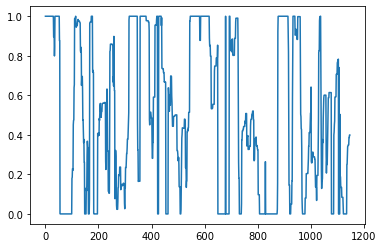

In [6]:
fig, ax = plt.subplots()

ax.plot(paired_ds.index, neutral_wet_usdm)

Cool. Let's wrap that up in a little function for ease and start looping through all our combinations.

In [7]:
def cat_area_frac(da:xr.DataArray, cat_val:int):
    """Fraction of non-nan area within a given drought category.

    This function is applied at every index increment, collapsing
    the data from spatio-temporal to just temporal.

    Parameters
    ----------
    da : xr.DataArray
        Contains data categorized according to USDM drought categories.
        Expecting `index` to be the temporal dimension.
    cat_val : int
        Category value to compute fraction over. For example, neutral or
        wet corresponds to -1, D0 to 0, D1 to 1, D2 to 2, D3 to 3, and
        D4 to 4.

    Returns
    -------
    list
        Fractions of area in drought category ordered in the same order
        as the index dimension.

    """

    tot_cells = (np.isnan(da.sel(index=0).values) == False).sum()
    cat_cells = [(da.sel(index=i).values == cat_val).sum() for i in da.index]
    percents = cat_cells/tot_cells

    return percents

def compile_cat_area_fracs(da:xr.DataArray, var_prefix=None):
    """Applies cat_area_frac to categories neutral to D4.

    Parameters
    ----------
    da : xr.DataArray
        Data categorized to the USDM drought categories, where
        -1 is netural or wet, 0 is D0, 1 is D1, 2 is D2, 3 is D3,
        and 4 is D4. Expecting `index` to be the temporal dimension.
    var_prefix : str, (optional)
        Append a prefix to the variables in the xarray Dataset that
        will be returned, should you aim to concat them into a larger
        dataset.
    
    Returns
    -------
    xr.Dataset
        Dataset containing fraction of non-nan area in each USDM
        drought category, using the `index` dimension from the
        provided variable `da`.
        
    """

    neutral_wet = cat_area_frac(da, -1)
    d0 = cat_area_frac(da, 0)
    d1 = cat_area_frac(da, 1)
    d2 = cat_area_frac(da, 2)
    d3 = cat_area_frac(da, 3)
    d4 = cat_area_frac(da, 4)

    index = da.index.values

    ds = xr.Dataset(
        coords=dict(
            index=index
        ),
        data_vars=dict(
            neutral_wet=(["index"], neutral_wet),
            D0=(["index"], d0),
            D1=(["index"], d1),
            D2=(["index"], d2),
            D3=(["index"], d3),
            D4=(["index"], d4),
        ),
        attrs=dict(
            {
                'description':'Fraction of total non-nan area that is in that USDM drought category for the given index.'
            }
        )
    )

    if var_prefix:
        ds = ds.rename({
            "neutral_wet":f"{var_prefix}_neutral_wet",
            "D0":f"{var_prefix}_D0",
            "D1":f"{var_prefix}_D1",
            "D2":f"{var_prefix}_D2",
            "D3":f"{var_prefix}_D3",
            "D4":f"{var_prefix}_D4"
        })

    return ds


Now did it work ...

In [8]:
usdm_af = compile_cat_area_fracs(paired_ds['USDM'], var_prefix="USDM")
usdm_af

<xarray.Dataset>
Dimensions:           (index: 1148)
Coordinates:
  * index             (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
Data variables:
    USDM_neutral_wet  (index) float64 1.0 1.0 1.0 1.0 ... 0.3866 0.3989 0.3994
    USDM_D0           (index) float64 0.0 0.0 0.0 0.0 ... 0.04413 0.0394 0.03567
    USDM_D1           (index) float64 0.0 0.0 0.0 0.0 ... 0.2084 0.2225 0.2451
    USDM_D2           (index) float64 0.0 0.0 0.0 0.0 ... 0.2044 0.2265 0.216
    USDM_D3           (index) float64 0.0 0.0 0.0 0.0 ... 0.1565 0.1127 0.1038
    USDM_D4           (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  Fraction of total non-nan area that is in that USDM drought...

Woot.

In [9]:
cat_af_list = [usdm_af]

for interval in tqdm(spi_intervals):
    spi_af = compile_cat_area_fracs(paired_ds[f'spi_{interval}'], var_prefix=f"spi_{interval}")
    cat_af_list.append(spi_af)
    spi_af = None

  0%|          | 0/8 [00:00<?, ?it/s]

In [10]:
cat_af_ds = xr.merge(cat_af_list)
cat_af_ds

<xarray.Dataset>
Dimensions:               (index: 1148)
Coordinates:
  * index                 (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
Data variables: (12/54)
    USDM_neutral_wet      (index) float64 1.0 1.0 1.0 ... 0.3866 0.3989 0.3994
    USDM_D0               (index) float64 0.0 0.0 0.0 ... 0.04413 0.0394 0.03567
    USDM_D1               (index) float64 0.0 0.0 0.0 ... 0.2084 0.2225 0.2451
    USDM_D2               (index) float64 0.0 0.0 0.0 ... 0.2044 0.2265 0.216
    USDM_D3               (index) float64 0.0 0.0 0.0 ... 0.1565 0.1127 0.1038
    USDM_D4               (index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                    ...
    spi_270d_neutral_wet  (index) float64 0.5527 0.5833 0.6667 ... 0.4802 0.5023
    spi_270d_D0           (index) float64 0.08534 0.09859 ... 0.06578 0.0665
    spi_270d_D1           (index) float64 0.1769 0.1468 0.1102 ... 0.2603 0.2643
    spi_270d_D2           (index) float64 0.02587 0.02994 ... 0.05173 0.0471
    spi_270d_D3           (index) float64 0.04407 0.03912 ... 0.0768 0.05964
    spi_270d_D4           (index) float64 0.1151 0.1023 ... 0.06522 0.06019
Attributes:
    description:  Fraction of total non-nan area that is in that USDM drought...

In [11]:
dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])
dm_vars

['USDM',
 'spi_1y',
 'spi_2y',
 'spi_5y',
 'spi_14d',
 'spi_30d',
 'spi_90d',
 'spi_180d',
 'spi_270d']

In [12]:
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

Alrighty, now let's make some plots!

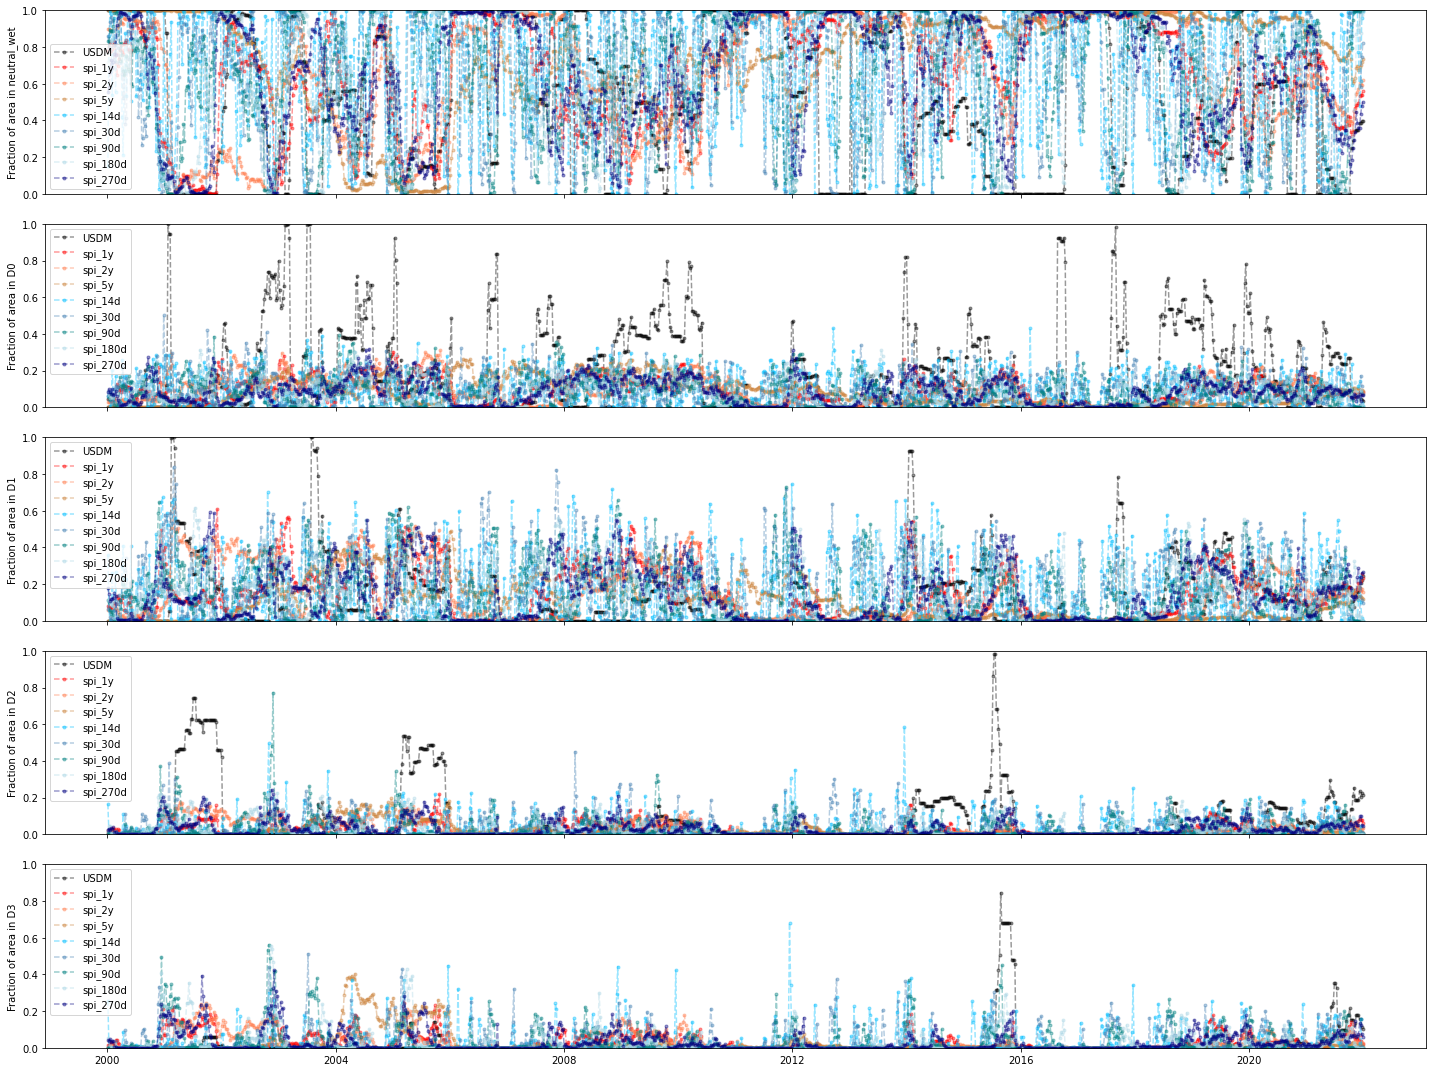

In [13]:
fig, axs = plt.subplots(5,1, figsize=(20,15), sharex=True)

times = paired_ds['USDM Date'].values
colors = ['black', 'red', 'coral', 'peru', 'deepskyblue', 'steelblue', 'teal', 'lightblue', 'navy']

for cat, ax in zip(cats, axs.ravel()):
    for dm_var, color in zip(dm_vars, colors):
        ax.plot(times, cat_af_ds[f'{dm_var}_{cat}'].values, label=dm_var, marker='.', linestyle='--', color=color, alpha=0.4)

    ax.set_ylabel(f'Fraction of area in {cat}')
    ax.set_ylim(0,1)
    ax.legend()

plt.tight_layout()

Well that's pretty ... don't know how helpful though. Maybe use datashader for better colors ... https://datashader.org/

In [14]:
1/tot_cells

8.295313148071339e-05

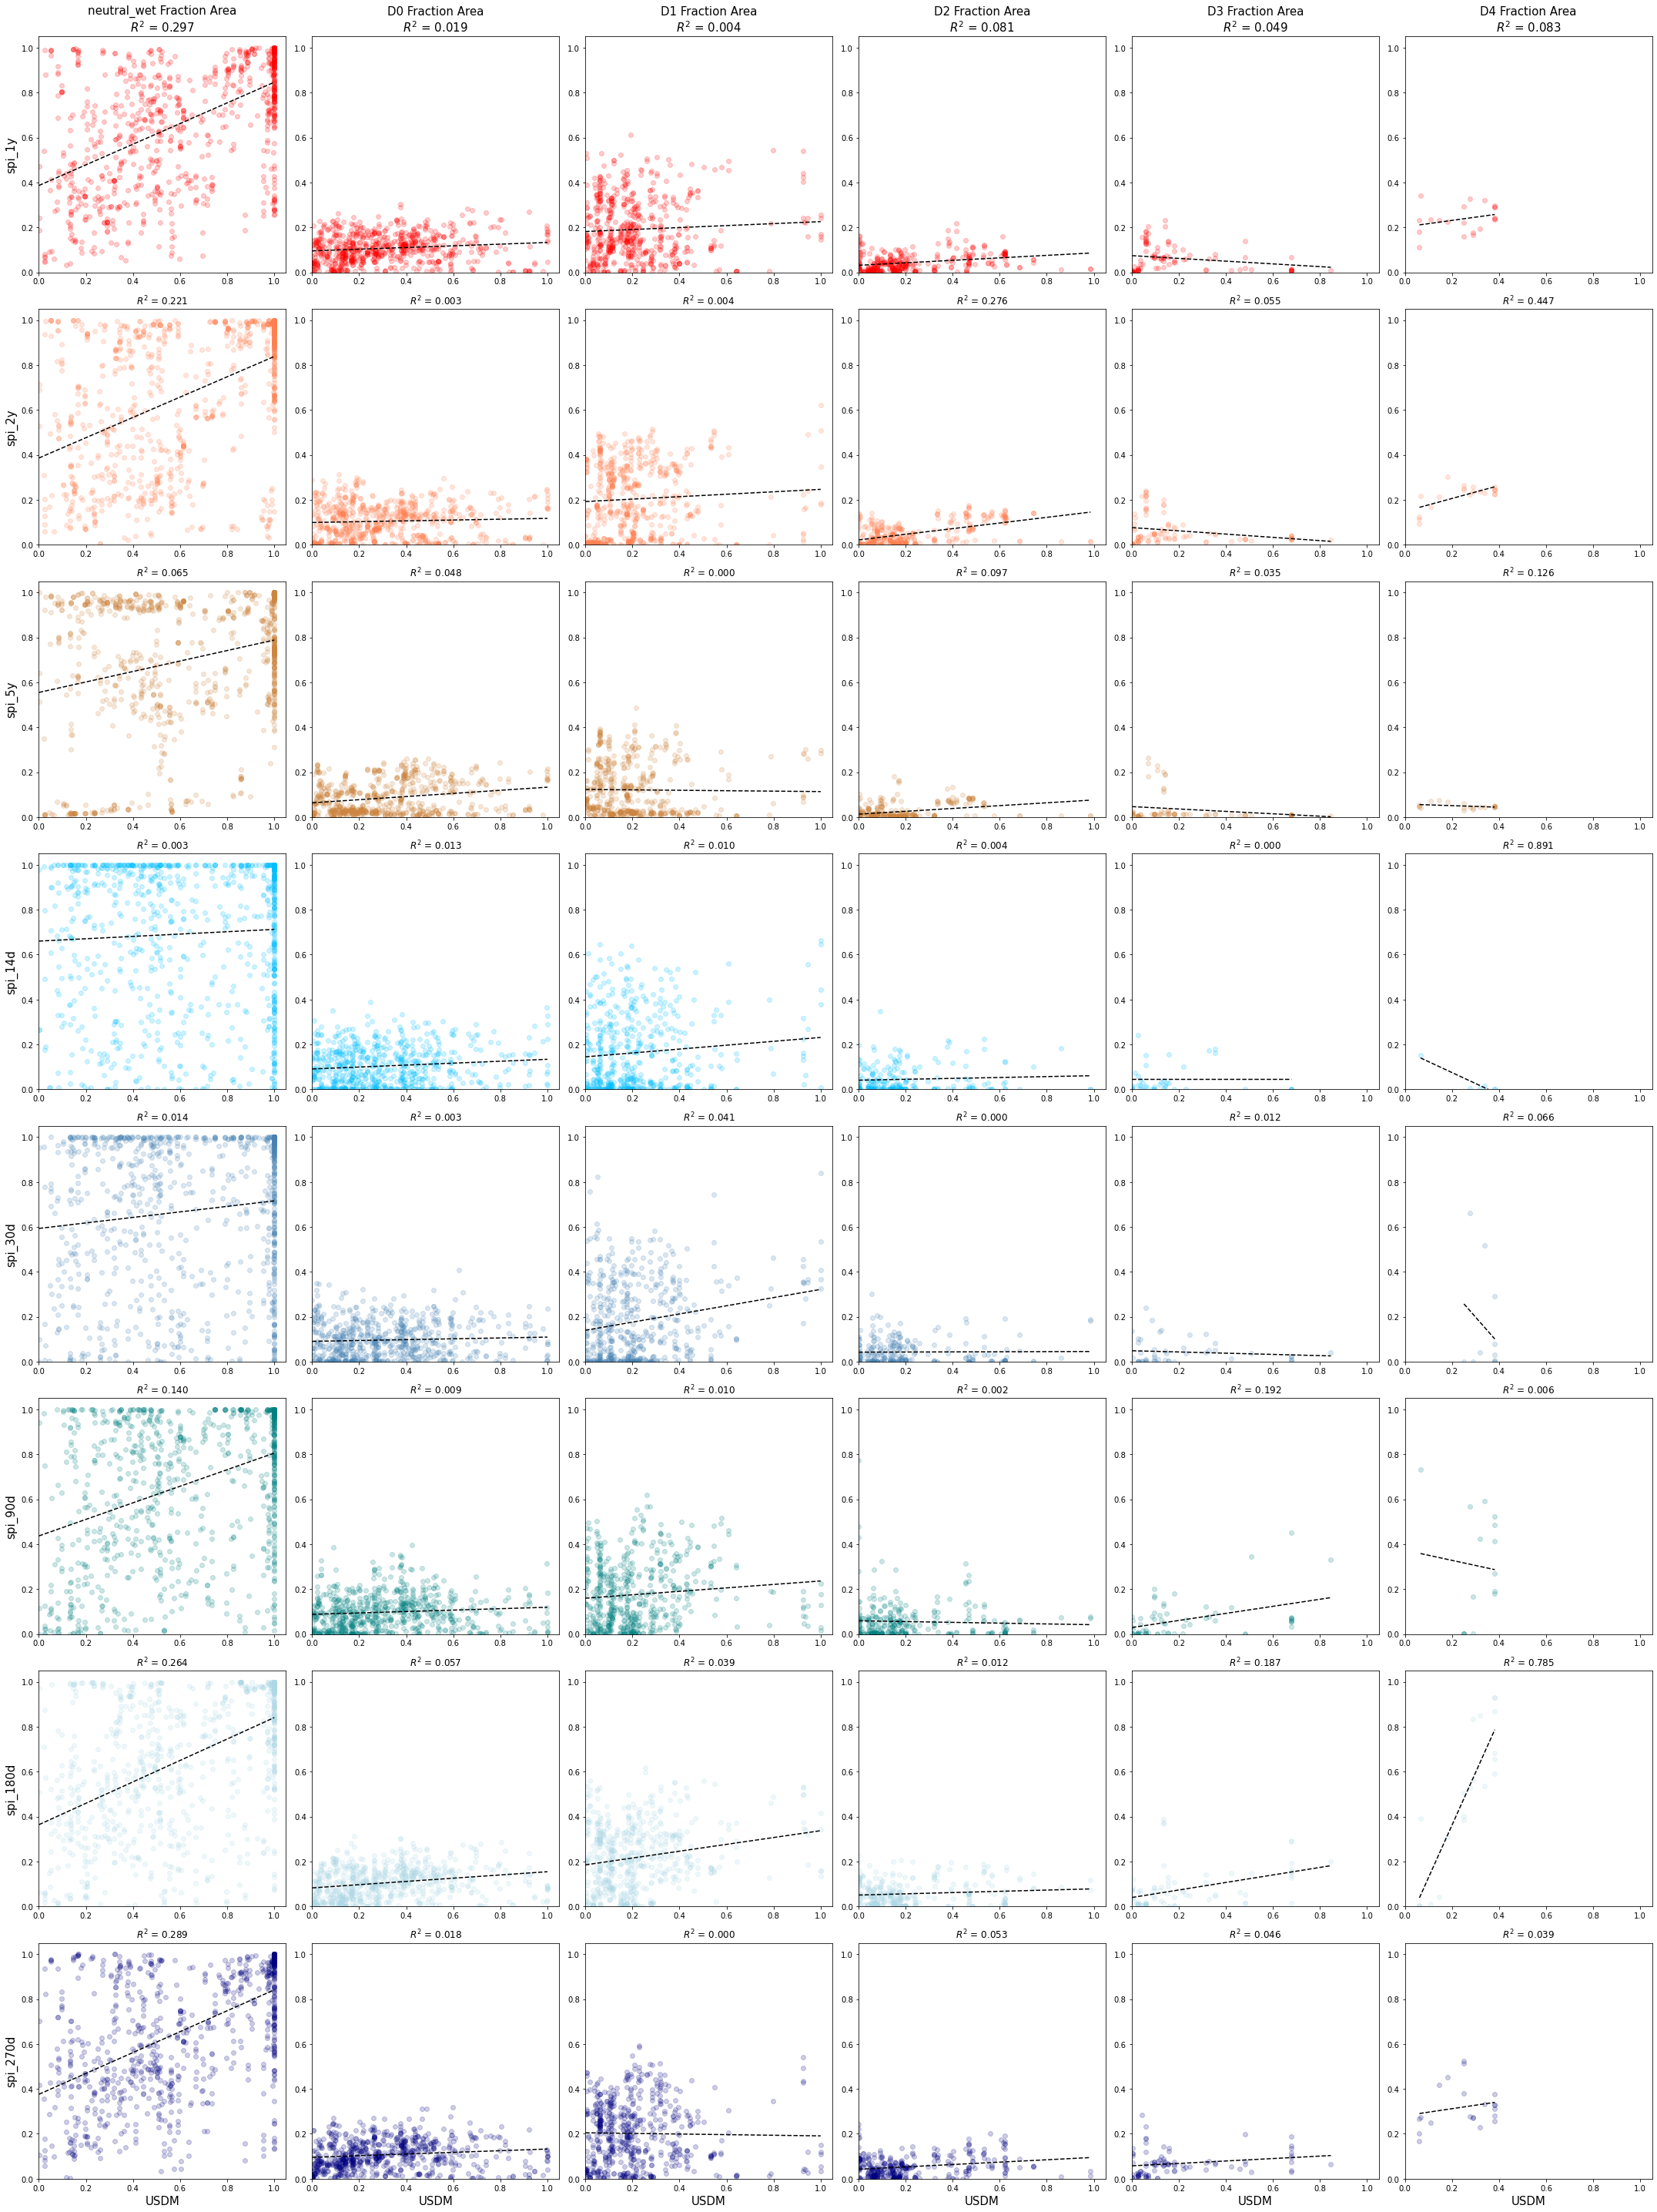

In [15]:
fig, axs = plt.subplots(8, 6, figsize=(30,5*8))

for j, cat in enumerate(cats):
    usdm_af_vals = cat_af_ds[f'USDM_{cat}'].values
    for i, (dm_var, color) in enumerate(zip(dm_vars[1:], colors[1:])):
        
        ax = axs[i,j]

        # let's not plot when they're zero
        x, y = wrangle.threshold_filtered_pair(usdm_af_vals, cat_af_ds[f'{dm_var}_{cat}'], minx=1e-6, miny=1e-6)
        #ax.scatter(x, y, )
        ndplot.scatter_linregress(x, y, ax=ax, model_color='k', color=color, alpha=0.2)

        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1.05)
    
        if j == 0:
            ax.set_ylabel(f'{dm_var}', fontsize=15)
        if i == 0:
            title = ax.get_title()
            ax.set_title(f'{cat} Fraction Area\n{title}', fontsize=15)
        if i == 7:
            ax.set_xlabel(f'USDM', fontsize=15)

plt.tight_layout()

Hm, so there isn't one that really stands out as being super informative. A multiple linear regression of sorts may prove better? I'm uncertain ...

What if I break it down by regions or something? Something that might have a more natural grouping and better represent the varied climates and hydrology of WA ...

Counties aren't per-say scientific ... but they do fall on the political lines that we might be interested in ... and do serve as smaller parsing

Yeah looking back at the spatial comparisons, there is a lot of spatial heterogeneity. Let's break this up a bit more.

Just used `query/query_huc_boundaries.ipynb` to get huc4 and huc8 geometries ... let's try grouping by those.

In [16]:
huc4 = gpd.read_file('../../data/geometry/huc4.geojson')
huc8 = gpd.read_file('../../data/geometry/huc8.geojson')

In [17]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 0
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26
Attributes:
    author:       a. stein 5/2/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

In [18]:
huc4.geometry

0    POLYGON ((-116.71934 47.09248, -116.71934 47.0...
1    POLYGON ((-117.63186 50.07614, -117.63186 50.0...
2    POLYGON ((-121.11362 47.59723, -121.11398 47.5...
3    POLYGON ((-121.11362 47.59723, -121.11352 47.5...
4    POLYGON ((-121.52268 46.87346, -121.52278 46.8...
5    POLYGON ((-122.44586 46.68302, -122.44540 46.6...
6    POLYGON ((-117.94719 45.87704, -117.94622 45.8...
7    POLYGON ((-116.71934 47.09248, -116.71934 47.0...
Name: geometry, dtype: geometry

In [19]:
type(huc4.geometry)

geopandas.geoseries.GeoSeries

In [20]:
paired_ds = paired_ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
paired_ds = paired_ds.rio.write_crs('EPSG:4326')

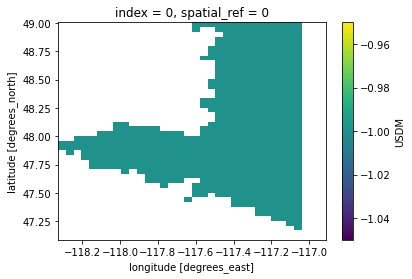

In [21]:
paired_ds.rio.clip([huc4.geometry.iloc[0]]).isel(index=0)['USDM'].plot()

In [22]:
paired_ds.rio.clip([huc4.geometry.iloc[0]])

<xarray.Dataset>
Dimensions:      (lat: 46, lon: 34, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 47.19 47.15 47.11
  * lon          (lon) float64 -118.3 -118.3 -118.2 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
    spatial_ref  int64 0
Data variables:
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_2y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_5y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_14d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_30d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_90d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_180d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_270d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SPI Date     (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26
Attributes:
    author:       a. stein 5/2/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

That's good I can just apply that to the whole dataset.

Well there appears to be no spatial groupby ... so loooooooooks like we're writing a function.

In [58]:
huc4.geometry[0].bounds

(-118.34057384966869,
 47.03960215833618,
 -116.16482891242094,
 49.470306995197404)

In [ ]:
huc4.geometry[0].bounds

In [63]:
def apply_by_geometries(da:xr.DataArray, geometries:gpd.GeoSeries, func, **func_kwargs):
    """Apply a function to the data based on the GeoSeries.

    Parameters
    ----------
    da : xr.DataArray
        Data to apply function to.
    geometries : gpd.GeoSeries
        Contains geometries to clip the data to.
    func : function
        Function to apply to da.
    **func_kwargs, (optional)
        Keyword arguments for func.
    
    Returns
    -------
    list
        Data after function has been applied to each geometric region, 
        in the same order as geometries.
        
    """

    applied = []
    
    for geo in tqdm(geometries, total=len(geometries)):
        minx, miny, maxx, maxy = geo.bounds
        # clipping to box first reduces total data working with for clip
        clipping = (da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)).rio.clip([geo])
        post_op = func(clipping, **func_kwargs)
        applied.append(post_op)

    return applied

suggestion to speed up from Eli

```
gdf.geometry.apply(
    lambda g:
        [xr_da.rio.clip_box(g.bounds).clip(g)]
)
```

In [64]:
usdm_da = paired_ds['USDM']
usdm_da = usdm_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
usdm_da = usdm_da.rio.write_crs('EPSG:4326')

usdm_huc4_af_list = apply_by_geometries(usdm_da, huc4.geometry, wrangle.compile_cat_area_fracs, var_prefix='USDM')

  0%|          | 0/8 [00:00<?, ?it/s]

Alright, that ran without error, nice.

In [65]:
usdm_huc4_af_list

[<xarray.Dataset>
 Dimensions:           (index: 1148)
 Coordinates:
   * index             (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
 Data variables:
     USDM_neutral_wet  (index) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
     USDM_D0           (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     USDM_D1           (index) float64 0.0 0.0 0.0 0.0 ... 0.2717 0.528 0.8851
     USDM_D2           (index) float64 0.0 0.0 0.0 0.0 ... 0.7267 0.472 0.1149
     USDM_D3           (index) float64 0.0 0.0 0.0 0.0 ... 0.001553 0.0 0.0
     USDM_D4           (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
 Attributes:
     description:  Fraction of total non-nan area that is in that USDM drought...,
 <xarray.Dataset>
 Dimensions:           (index: 1148)
 Coordinates:
   * index             (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
 Data variables:
     USDM_neutral_wet  (index) float64 1.0 1.0 1.0 1.0 ... 0.0834 0.08489 0.08564
     USDM_D0           

In [66]:
usdm_huc4_af = xr.concat(usdm_huc4_af_list, dim='huc4')
usdm_huc4_af['huc4'] = huc4.HUC4.values
usdm_huc4_af['huc4_name'] = xr.DataArray(huc4.Name.values, coords=dict(huc4=huc4.HUC4.values))
usdm_huc4_af

<xarray.Dataset>
Dimensions:           (huc4: 8, index: 1148)
Coordinates:
  * index             (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
  * huc4              (huc4) object '1701' '1702' '1703' ... '1707' '1706'
Data variables:
    USDM_neutral_wet  (huc4, index) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    USDM_D0           (huc4, index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    USDM_D1           (huc4, index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.01594
    USDM_D2           (huc4, index) float64 0.0 0.0 0.0 ... 0.1544 0.6624 0.7181
    USDM_D3           (huc4, index) float64 0.0 0.0 0.0 ... 0.8456 0.3376 0.2659
    USDM_D4           (huc4, index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    huc4_name         (huc4) object 'Kootenai-Pend Oreille-Spokane' ... 'Lowe...
Attributes:
    description:  Fraction of total non-nan area that is in that USDM drought...

fig, axs = plt.subplots(5,1, figsize=(15,15))

huc4_list = usdm_huc4_af['huc4'].values

for ax, cat in zip(axs.ravel(), cats):
    for huc in huc4_list:
        ax.plot(usdm_huc4_af[f'USDM_{cat}'].sel(huc4=huc), label=huc)

plt.tight_layout()

Well that works for proof of concept at least. Let's see if this improves the scatters. I'm not super interested in the timeseries.

In [73]:
paired_huc4_list = []

for dm_var in dm_vars:
    dm_da = paired_ds[dm_var]
    dm_da = dm_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    dm_da = dm_da.rio.write_crs('EPSG:4326')
    dm_huc4 = apply_by_geometries(dm_da, huc4.geometry, wrangle.compile_cat_area_fracs, var_prefix=dm_var)
    dm_huc4_ds = xr.concat(dm_huc4, dim='huc4')
    dm_huc4_ds['huc4'] = huc4.HUC4.values
    paired_huc4_list.append(dm_huc4_ds)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [81]:
paired_huc4_ds = xr.merge(paired_huc4_list)
paired_huc4_ds['huc4_name'] = xr.DataArray(huc4.Name.values, coords=dict(huc4=huc4.HUC4.values))
paired_huc4_ds

<xarray.Dataset>
Dimensions:               (huc4: 8, index: 1148)
Coordinates:
  * index                 (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
  * huc4                  (huc4) object '1701' '1702' '1703' ... '1707' '1706'
Data variables: (12/55)
    USDM_neutral_wet      (huc4, index) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    USDM_D0               (huc4, index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    USDM_D1               (huc4, index) float64 0.0 0.0 0.0 ... 0.0 0.0 0.01594
    USDM_D2               (huc4, index) float64 0.0 0.0 0.0 ... 0.6624 0.7181
    USDM_D3               (huc4, index) float64 0.0 0.0 0.0 ... 0.3376 0.2659
    USDM_D4               (huc4, index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    spi_270d_D0           (huc4, index) float64 0.2326 0.2356 ... 0.04836
    spi_270d_D1           (huc4, index) float64 0.3293 0.1103 ... 0.5513 0.5609
    spi_270d_D2           (huc4, index) float64 0.007553 0.0 ... 0.1731 0.1296
    spi_270d_D3           (huc4, index) float64 0.001511 0.0 ... 0.1538 0.1286
    spi_270d_D4           (huc4, index) float64 0.0 0.0 0.0 ... 0.117 0.1325
    huc4_name             (huc4) object 'Kootenai-Pend Oreille-Spokane' ... '...
Attributes:
    description:  Fraction of total non-nan area that is in that USDM drought...

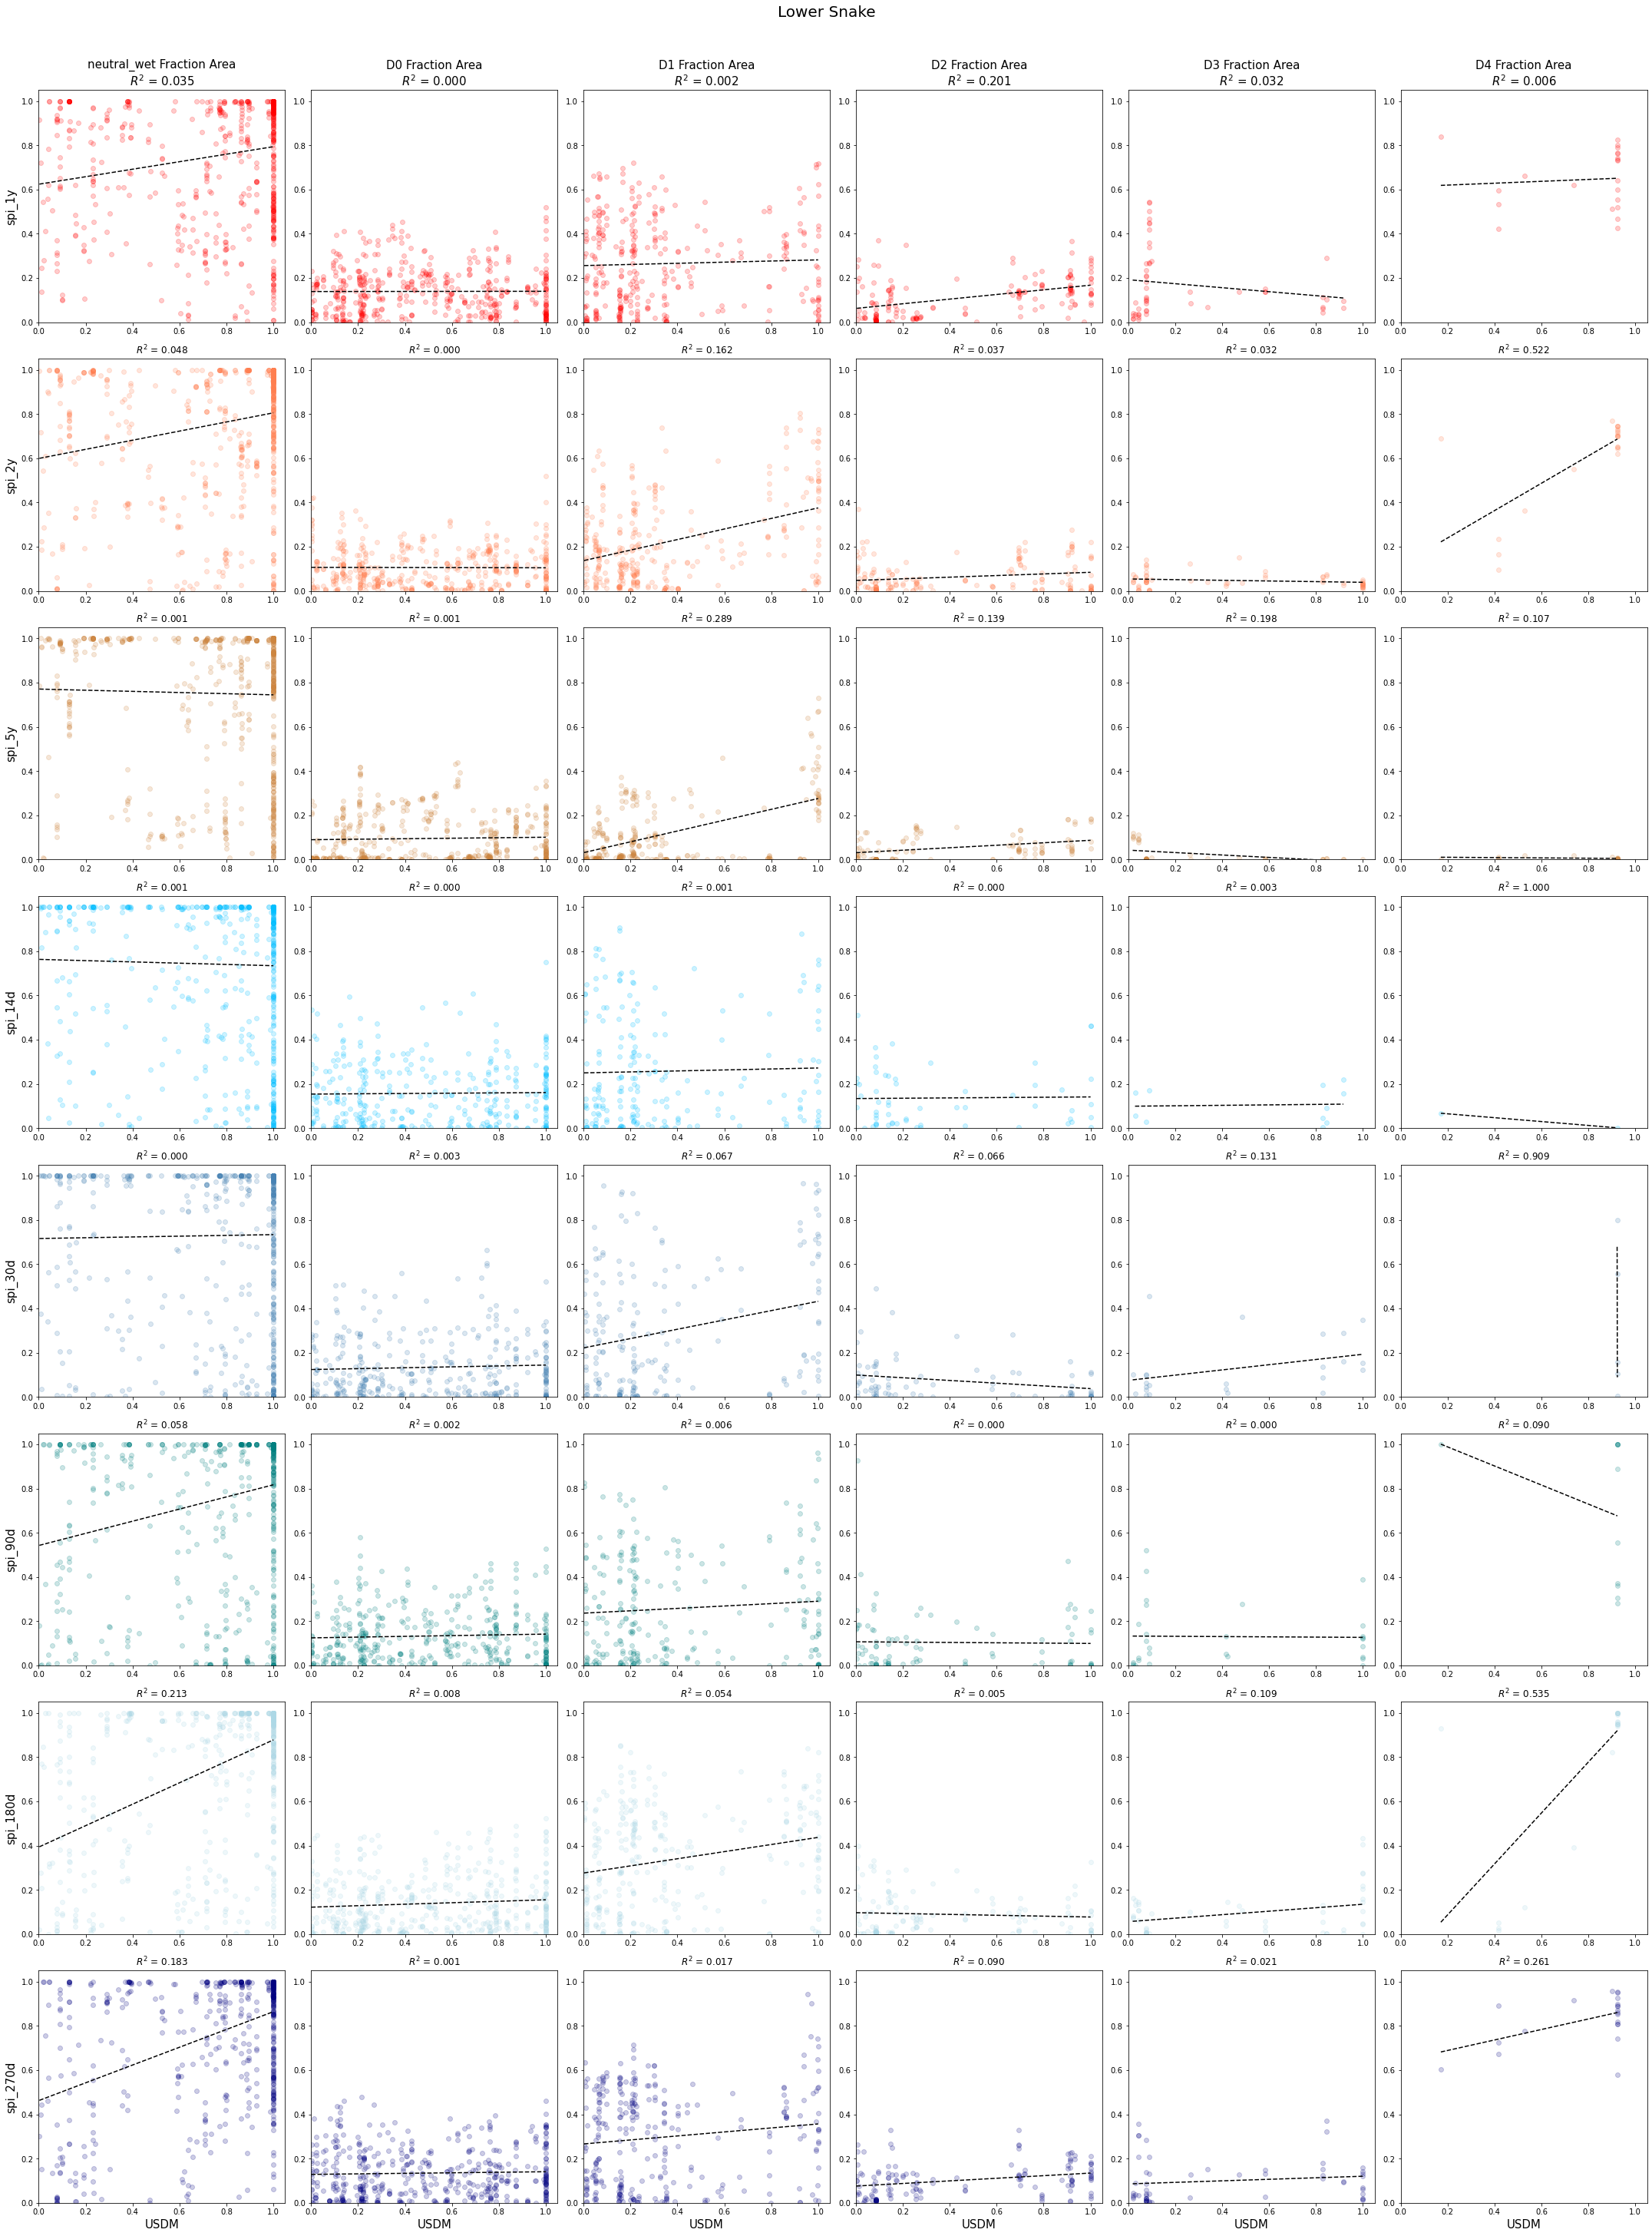

In [98]:
fig, axs = plt.subplots(8, 6, figsize=(30,5*8))

huc_idx = 7
huc_num = paired_huc4_ds['huc4'].values[huc_idx]
huc_name = paired_huc4_ds['huc4_name'].values[huc_idx]

for j, cat in enumerate(cats):
    usdm_af_vals = paired_huc4_ds.sel(huc4=huc_num)[f'USDM_{cat}'].values
    for i, (dm_var, color) in enumerate(zip(dm_vars[1:], colors[1:])):
        
        ax = axs[i,j]
        try:
            # let's not plot when they're zero
            x, y = wrangle.threshold_filtered_pair(usdm_af_vals, paired_huc4_ds.sel(huc4=huc_num)[f'{dm_var}_{cat}'], minx=1e-6, miny=1e-6)
            #ax.scatter(x, y, )
            ndplot.scatter_linregress(x, y, ax=ax, model_color='k', color=color, alpha=0.2)

            ax.set_xlim(0, 1.05)
            ax.set_ylim(0, 1.05)
        
            if j == 0:
                ax.set_ylabel(f'{dm_var}', fontsize=15)
            if i == 0:
                title = ax.get_title()
                ax.set_title(f'{cat} Fraction Area\n{title}', fontsize=15)
            if i == 7:
                ax.set_xlabel(f'USDM', fontsize=15)
        except:
            pass

fig.suptitle(huc_name, fontsize=20, y=1.01)
plt.tight_layout()

In [100]:
paired_huc4_ds.to_netcdf('../../data/drought_measures/ndrought_products/paired_USDM_SPI_huc4split.nc')

Still not really any strong correlations. Iterated through each of the basins in huc4 ... let's try increasing the resolution once more by using huc8 and then I'll move on.

In [101]:
paired_huc8_list = []

for dm_var in dm_vars:
    dm_da = paired_ds[dm_var]
    dm_da = dm_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    dm_da = dm_da.rio.write_crs('EPSG:4326')
    dm_huc8 = apply_by_geometries(dm_da, huc8.geometry, wrangle.compile_cat_area_fracs, var_prefix=dm_var)
    dm_huc8_ds = xr.concat(dm_huc8, dim='huc8')
    dm_huc8_ds['huc8'] = huc8.HUC8.values
    paired_huc8_list.append(dm_huc8_ds)

  0%|          | 0/72 [00:00<?, ?it/s]

Oh frick, that's going to take like 32 minutes. We should save that out once done

In [ ]:
paired_huc8_ds = xr.merge(paired_huc8_list)
paired_huc8_ds['huc8_name'] = xr.DataArray(huc8.Name.values, coords=dict(huc8=huc8.HUC8.values))
paired_huc8_ds

In [ ]:
paired_huc8_ds.to_netcdf('../../data/drought_measures/ndrought_products/paired_USDM_SPI_huc8split.nc')